In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfd = tfp.distributions
np.random.seed(1234)

sns.set(style="white")

In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.1.0
The tensorflow version is 2.2.0
The tensorflow-probability version is 0.10.1


In [3]:
gpflow.config.set_default_summary_fmt("notebook")

In [4]:
def plot_prediction(X, Y, model, X_test=None, Y_test=None, num_samples=20):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    Xnew = np.linspace(X.min(axis=0) - 0.5, X.max(axis=0) + 0.5, 100)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=num_samples)
    mean, var = model.predict_f(Xnew)
    
    ax.plot(Xnew.flatten(), np.squeeze(Ypred).T, "C1", alpha=0.2)
    ax.plot(Xnew.flatten(), mean, "-", c="C0")
    
    lo = (mean - 2 * tf.sqrt(var)).numpy()
    hi = (mean + 2 * tf.sqrt(var)).numpy()
    ax.fill_between(Xnew.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(X, Y, "o", c="C2", alpha=0.7, label="train")
    if (X_test is not None) and (Y_test is not None):
        ax.plot(X_test, Y_test, "o", c="C3", alpha=0.7, label="test")
        ax.legend()

In [5]:
def plot_kernel_sample(k, xmin=0, xmax=3, other=0):
    f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
    
    xx = np.linspace(xmin, xmax, 300)[:, None]
    K = k(xx)
    axes[0].plot(xx, np.random.multivariate_normal(np.zeros(300), K, 5).T)
    axes[0].set_title("Samples " + k.__class__.__name__)
    
    axes[1].plot(xx, k(xx, np.zeros((1, 1)) + other))
    axes[1].set_title(k.__class__.__name__ + " k(x, %.1f)" % other)

## Load Datasets UK

The second data come from microsoft [link](https://github.com/microsoft/Bing-COVID-19-Data). This set includes recovered, so we can calculate the number of infected, recovered and susceptible as a function of time. 

#### Mobility

In [6]:
mobility_data = pd.read_csv(
    "../Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"]
)

/Users/N547113/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Cases

In [7]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "../Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"]
)
ms_uk_covid = ms_covid[(ms_covid["Country_Region"]=="United Kingdom") & (ms_covid["AdminRegion1"].isnull())]
ms_uk_covid = ms_uk_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_uk_covid.reset_index(drop=True, inplace=True)

In [8]:
# Create the 3 categories S, I, R for US data (UK does not include R)
ms_uk_covid.fillna(0, inplace=True)
ms_uk_covid["I"] = ms_uk_covid["Confirmed"] - ms_uk_covid["Deaths"] - ms_uk_covid["Recovered"]

ms_uk_covid["S"] = 51000000 - ms_uk_covid["I"]

ms_uk_covid["index"] = ms_uk_covid["Updated"].dt.dayofyear

In [9]:
# drop the last value because it looks wrong
ms_uk_covid = ms_uk_covid[:-1].copy()

In [10]:
# UK
ms_uk_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 8 columns):
Updated            207 non-null datetime64[ns]
Confirmed          207 non-null int64
ConfirmedChange    207 non-null float64
Deaths             207 non-null float64
Recovered          207 non-null float64
I                  207 non-null float64
S                  207 non-null float64
index              207 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 13.0 KB


In [11]:
ms_uk_covid.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index
0,2020-01-31,2,0.0,0.0,0.0,2.0,50999998.0,31
1,2020-02-01,2,0.0,0.0,0.0,2.0,50999998.0,32
2,2020-02-02,2,0.0,0.0,0.0,2.0,50999998.0,33
3,2020-02-03,2,0.0,0.0,0.0,2.0,50999998.0,34
4,2020-02-04,2,0.0,0.0,0.0,2.0,50999998.0,35


In [12]:
mobility_data.dtypes

country_region_code                                           object
country_region                                                object
sub_region_1                                                  object
sub_region_2                                                  object
metro_area                                                    object
iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

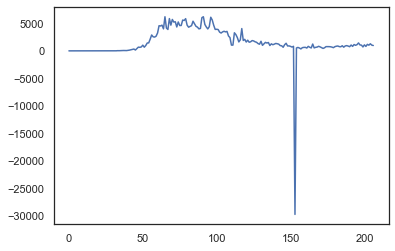

In [13]:
plt.plot(ms_uk_covid["ConfirmedChange"])

In [14]:
s = ms_uk_covid["ConfirmedChange"]
f = (np.abs(s) > 3 * np.std(s))

ms_uk_covid.loc[f, "ConfirmedChange"] = np.nan
ms_uk_covid["ConfirmedChange"].fillna(method="ffill", inplace=True)

# Explore the Google Mobility Dataset

From the Google Mobility data we keep only the general UK cases. We do not go down to LAD (lower administrative level).

We do the same for the US cases

In [15]:
mobility_data_uk = mobility_data[
    (mobility_data["country_region"]=="United Kingdom") & (mobility_data["sub_region_1"].isnull())
]
mobility_data_uk = mobility_data_uk.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_uk.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [16]:
# transform the data to pct change
mobility_data_uk.iloc[:,1:] = mobility_data_uk.iloc[:,1:].apply(lambda x: x/100 + 1)

In [17]:
mobility_data_uk.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,0.88,0.93,0.65,0.88,0.96,1.02
1,2020-02-16,0.93,0.94,0.72,0.93,0.97,1.01
2,2020-02-17,1.10,1.01,1.24,0.98,0.86,1.02
3,2020-02-18,1.07,0.99,1.20,0.97,0.86,1.02
4,2020-02-19,1.06,0.98,1.08,0.96,0.86,1.03


Merge the Google mobility data to HOME, WORK, and OTHER, with the OTHER to include parks, transit, retail and grocery. 

In [18]:
data_uk = pd.DataFrame({
    "date": mobility_data_uk["date"],
    "HOME": mobility_data_uk['residential_percent_change_from_baseline'],
    "WORK": mobility_data_uk['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_uk['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_uk.iloc[:,2:5].mean(axis=1)
})

In [19]:
data_uk.head()

,date,HOME,WORK,RECREATIONAL,OTHER
0,2020-02-15,1.02,0.96,0.88,0.820000
1,2020-02-16,1.01,0.97,0.93,0.863333
2,2020-02-17,1.02,0.86,1.10,1.076667
3,2020-02-18,1.02,0.86,1.07,1.053333
4,2020-02-19,1.03,0.86,1.06,1.006667


<AxesSubplot:>

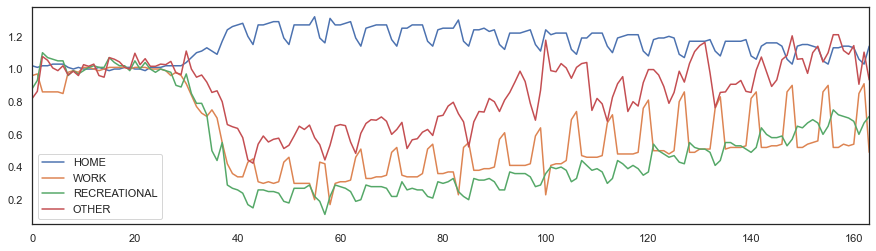

In [20]:
data_uk.drop(columns=["date"]).plot(figsize=(15, 4))

<AxesSubplot:>

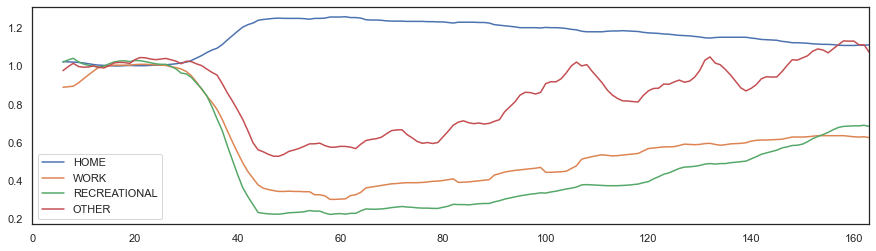

In [21]:
data_uk.drop(columns=["date"]).rolling(7).mean().plot(figsize=(15, 4))

# Visually explore the dataset

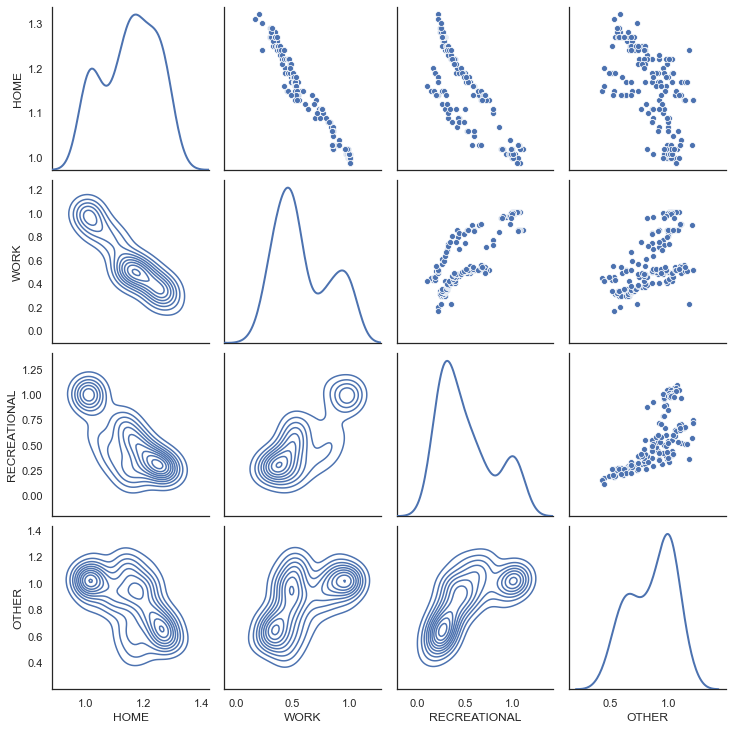

In [22]:
g = sns.PairGrid(data_uk, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

<AxesSubplot:>

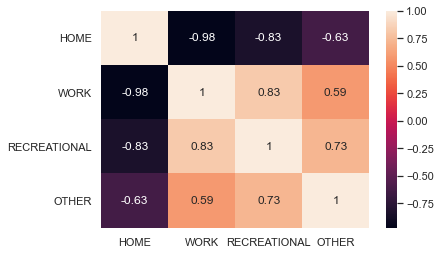

In [23]:
sns.heatmap(data_uk.corr(), annot=True)

# Merge the Datasets

In [24]:
ms_uk_covid.dtypes

Updated            datetime64[ns]
Confirmed                   int64
ConfirmedChange           float64
Deaths                    float64
Recovered                 float64
I                         float64
S                         float64
index                       int64
dtype: object

In [25]:
data_uk.dtypes

date            datetime64[ns]
HOME                   float64
WORK                   float64
RECREATIONAL           float64
OTHER                  float64
dtype: object

Merge the two datasets, the MS covid US and the Google mobility by date

In [26]:
final_data_uk = ms_uk_covid.set_index("Updated").merge(
    data_uk.set_index("date"), how='left', left_index=True, right_index=True
).reset_index()

In [27]:
final_data_uk.dropna(inplace=True)

In [28]:
final_data_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 3 to 189
Data columns (total 12 columns):
Updated            139 non-null datetime64[ns]
Confirmed          139 non-null int64
ConfirmedChange    139 non-null float64
Deaths             139 non-null float64
Recovered          139 non-null float64
I                  139 non-null float64
S                  139 non-null float64
index              139 non-null int64
HOME               139 non-null float64
WORK               139 non-null float64
RECREATIONAL       139 non-null float64
OTHER              139 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 14.1 KB


Merge the two datasets, UK mobility and ONS covid

# Include Mixing Matrix Information

In [29]:
# Create a combination of mixing matrices the same way they do in literature. 
# Fill NA values with 0

C_HOME = pd.read_csv("../Data/BBC/HOME.csv", index_col=0)

C_WORK = pd.read_csv("../Data/BBC/WORK.csv", index_col=0)

C_OTHER = pd.read_csv("../Data/BBC/OTHER.csv", index_col=0)

C = C_HOME + C_WORK + C_OTHER

C.fillna(0, inplace=True)

# Variational Bayesian non-parametric inference for infectious disease models

In this approach we follow Hensman and Kypraios paper. 

1. $\lambda(t) = \exp(f(t))$; the GP model depends only on time
2. $\lambda(t) = \beta(t)S(t)I(t)$ with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying
3. $\lambda(t) = \exp(f(S(t)I(t)))$; the GP model is a function of the product S(t)I(t)

We use UK data

In [30]:
final_data_uk["S*I"] = final_data_uk["S"]*final_data_uk["I"]

In [31]:
final_data_uk["Confirmed"] = final_data_uk["Confirmed"].astype("float64")
final_data_uk["index"] = final_data_uk["index"].astype("float64")
final_data_uk["index"] -= final_data_uk["index"].values[0] - 1.
final_data_uk.set_index("index", drop=False, inplace=True)
final_data_uk.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 139 entries, 1.0 to 187.0
Data columns (total 13 columns):
Updated            139 non-null datetime64[ns]
Confirmed          139 non-null float64
ConfirmedChange    139 non-null float64
Deaths             139 non-null float64
Recovered          139 non-null float64
I                  139 non-null float64
S                  139 non-null float64
index              139 non-null float64
HOME               139 non-null float64
WORK               139 non-null float64
RECREATIONAL       139 non-null float64
OTHER              139 non-null float64
S*I                139 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 15.2 KB


In [32]:
final_data_uk.shape

(139, 13)

In [33]:
final_data_uk.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,HOME,WORK,RECREATIONAL,OTHER,S*I
index,,,,,,,,,,,,,
1.0,2020-02-03,2.0,0.0,0.0,0.0,2.0,50999998.0,1.0,1.00,1.01,1.04,1.06,101999996.0
2.0,2020-02-04,2.0,0.0,0.0,0.0,2.0,50999998.0,2.0,1.29,0.30,0.25,0.57,101999996.0
3.0,2020-02-05,2.0,0.0,0.0,0.0,2.0,50999998.0,3.0,1.17,0.51,0.22,0.63,101999996.0
4.0,2020-02-06,3.0,1.0,0.0,0.0,3.0,50999997.0,4.0,1.19,0.46,0.41,1.04,152999991.0
5.0,2020-02-07,3.0,0.0,0.0,0.0,3.0,50999997.0,5.0,1.17,0.52,0.53,0.93,152999991.0


### Model 1: $\lambda(t) = \exp(f(t))$

In [34]:
y = final_data_uk[["ConfirmedChange"]].to_numpy()
X = final_data_uk[["index"]].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

In [35]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


**Likelihood**: The likelihood of the observed data is Poisson distribution

#### Poisson likelihood

In [36]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Poisson(), 
    kernel=k_slr
)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=20000))
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.0918749483304606
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.1756853156123985
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.091874948330472
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,2.0918749483304673
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.1961035771334896
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.9914650317605566
VGP.q_mu,Parameter,Identity,,True,"(111, 1)",float64,[[-7.77765050e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 111, 111)",float64,"[[[-1.34404662e+00, 0.00000000e+00, 0.00000000e+00..."


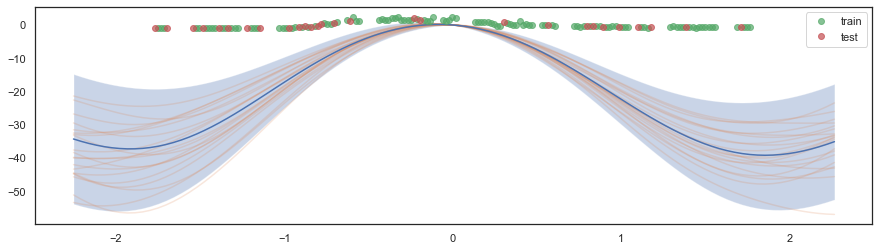

In [37]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [38]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 17.467328968338563, 'test', 22.491096754346813)

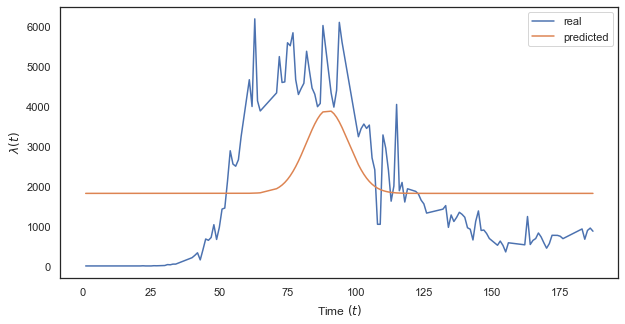

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_1 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(t_, final_data_uk["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_1, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

#### Gaussian likelihood

##### Kernel SE * LIN * RQ

In [40]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_slr
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.594899534123563
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.36663692996740227
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.5948995341235779
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.5948995341235734
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.0924826971498618
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1.6551182127098305
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.30538094500422475
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[-2.69914625e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[8.70871367e-02, 0.00000000e+00, 0.00000000e+00..."


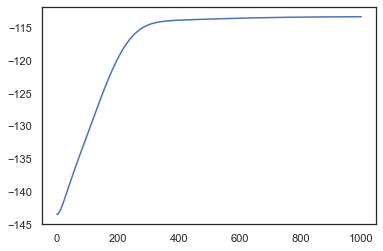

In [41]:
# ELBO
plt.plot(logf)

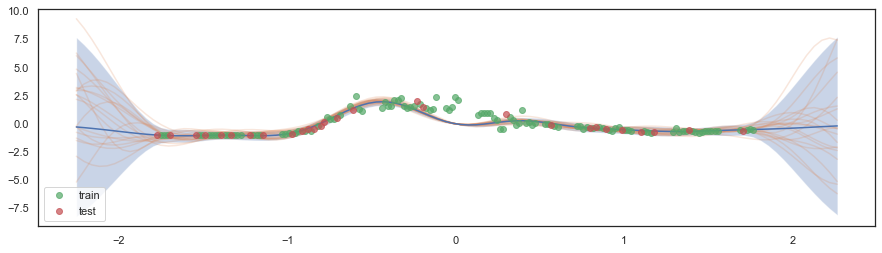

In [42]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [43]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.03127035184325355, 'test', 0.04050798885590901)

In [44]:
ms_uk_covid["ConfirmedChange"].min()

0.0

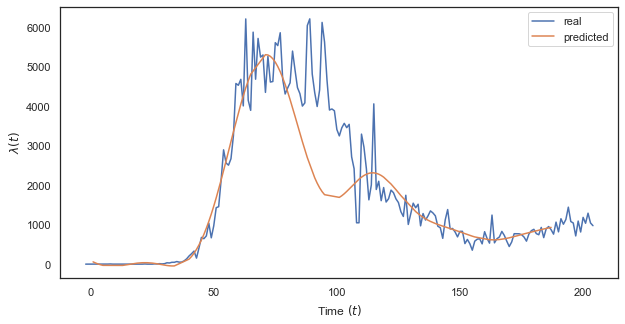

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_2 = y_scaler.inverse_transform(m.predict_f(X)[0].numpy())

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_2, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

##### Kernel Matern32

In [46]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_mtrn
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9366696246909677
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5667888737740194
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.08307823647421841
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[-7.10705779e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[1.36489475e-01, 0.00000000e+00, 0.00000000e+00..."


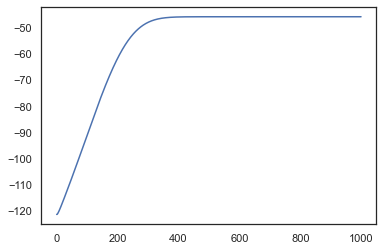

In [47]:
# ELBO
plt.plot(logf)

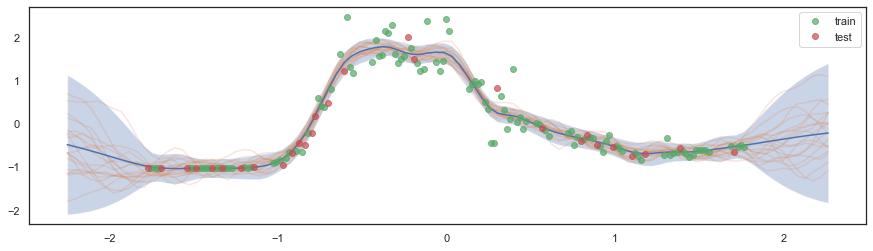

In [48]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [49]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.013048864515339462, 'test', 0.01514410660754585)

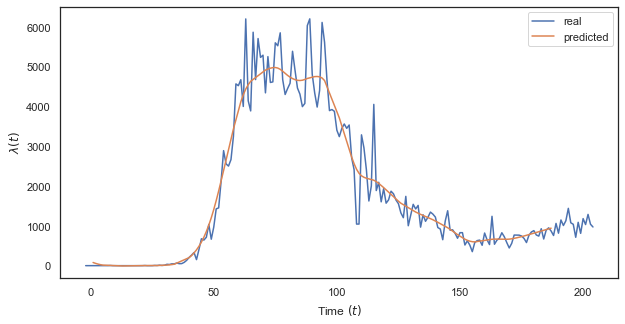

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_3 = y_scaler.inverse_transform(m.predict_f(X)[0].numpy())

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_3, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

#### Comments

The results from M1 $\lambda(t)$ = exp($f$(t)):

1. The Poisson likelihood does not perform very well compared to the Gaussian likelihood.
2. The Matern32 kernel and the SE\*LIN\*RQ perform similarly for a high number of iterations, but the matern32 kernel seems to reach a good solution faster.

### Model 2: $\lambda(t) = \beta(t)S(t)I(t) = \exp(f(t))S(t)I(t)$

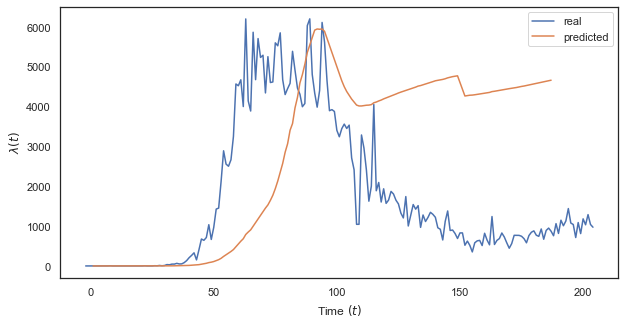

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_4 = y_1.reshape(-1) * final_data_uk["S*I"] / 51000000**2 * 500 # S(t) and I(t) are actually the densities

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_4, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

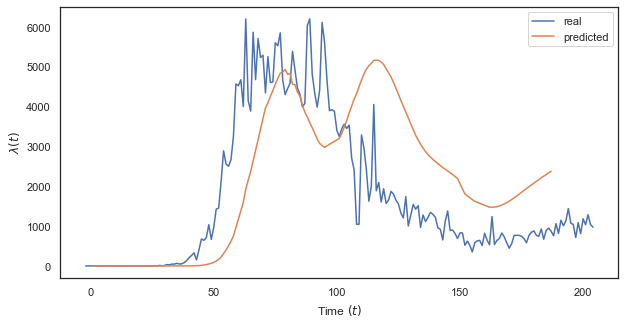

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_5 = y_2.reshape(-1) * final_data_uk["S*I"] / 51000000**2 * 500 # S(t) and I(t) are actually the densities

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_5, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

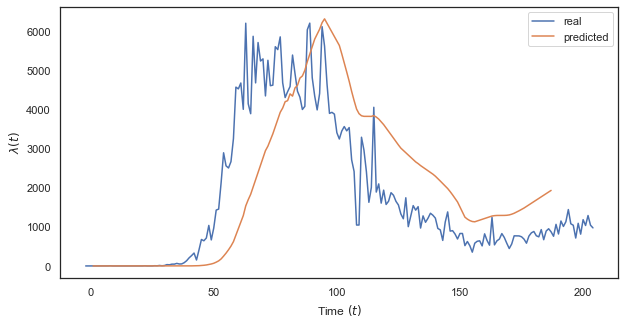

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_6 = y_3.reshape(-1) * final_data_uk["S*I"] / 51000000**2 * 400 # S(t) and I(t) are actually the densities

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_6, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

### Model 3: $\lambda(t) = \exp(f(S(t)I(t)))$

In [54]:
y = final_data_uk[["ConfirmedChange"]].to_numpy()
X = final_data_uk[["S*I"]].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

In [55]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


##### Kernel SE * LIN * RQ

In [56]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_slr
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.3462171744311218
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.25588374913185347
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.346217174431327
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,2.3462171744311213
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.45212490684769663
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,2.8725147306033043
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.17521923408804901
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[-9.89244201e-02...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[3.22574490e-02, 0.00000000e+00, 0.00000000e+00..."


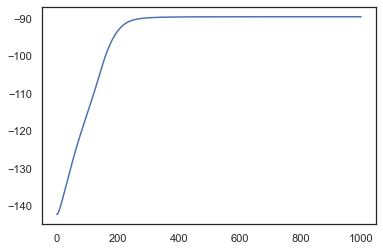

In [57]:
# ELBO
plt.plot(logf)

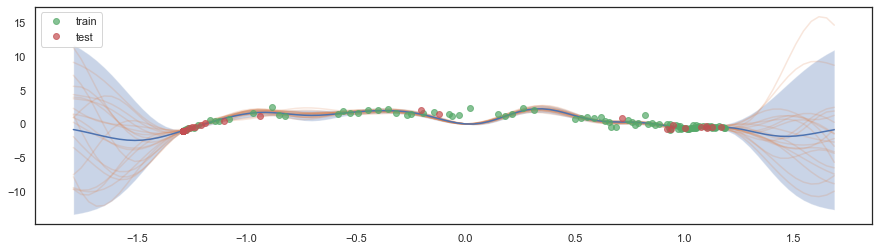

In [58]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [59]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.020675535560536782, 'test', 0.018509193530947522)

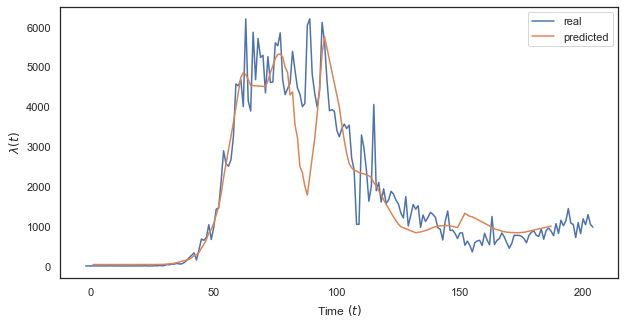

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_7 = y_scaler.inverse_transform(m.predict_f(X)[0].numpy())

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_7, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

##### Kernel Matern32

In [61]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_mtrn
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.463237675742734
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1747806351905767
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.045150575442026414
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[-3.51408254e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[7.26707786e-02, 0.00000000e+00, 0.00000000e+00..."


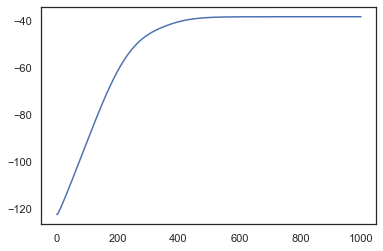

In [62]:
# ELBO
plt.plot(logf)

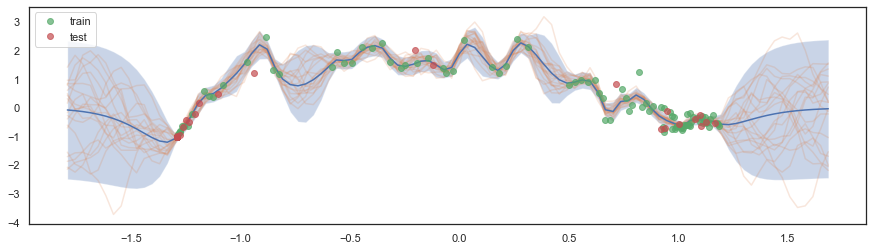

In [63]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [64]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.013528320771044577, 'test', 0.014301925464896737)

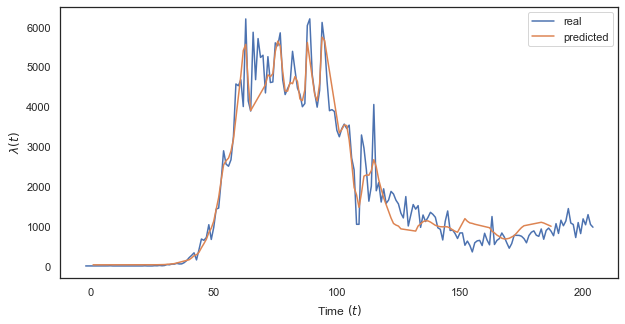

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_uk[["index"]].to_numpy().reshape(-1, 1)
y_8 = y_scaler.inverse_transform(m.predict_f(X)[0].numpy())

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_8, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

## Experiments

In [66]:
final_data_uk.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,HOME,WORK,RECREATIONAL,OTHER,S*I
index,,,,,,,,,,,,,
1.0,2020-02-03,2.0,0.0,0.0,0.0,2.0,50999998.0,1.0,1.00,1.01,1.04,1.06,101999996.0
2.0,2020-02-04,2.0,0.0,0.0,0.0,2.0,50999998.0,2.0,1.29,0.30,0.25,0.57,101999996.0
3.0,2020-02-05,2.0,0.0,0.0,0.0,2.0,50999998.0,3.0,1.17,0.51,0.22,0.63,101999996.0
4.0,2020-02-06,3.0,1.0,0.0,0.0,3.0,50999997.0,4.0,1.19,0.46,0.41,1.04,152999991.0
5.0,2020-02-07,3.0,0.0,0.0,0.0,3.0,50999997.0,5.0,1.17,0.52,0.53,0.93,152999991.0


In [67]:
final_data_uk_cp = final_data_uk.copy()


historical_window = 3

for i in range(1, historical_window+1):
    final_data_uk_cp[f"I-{i}"] = final_data_uk_cp["I"].shift(i)
final_data_uk_cp.dropna(inplace=True)

y = final_data_uk_cp[["ConfirmedChange"]].to_numpy()
X = final_data_uk_cp[
    [f"I-{i}" for i in range(1, historical_window+1)] + \
    ["I", "S", "WORK", "RECREATIONAL"]
].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


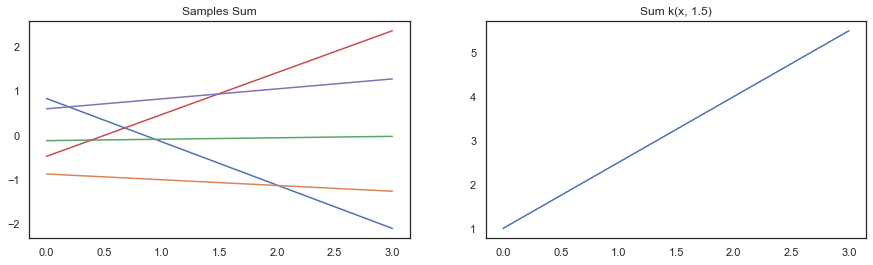

In [68]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

#gpflow.kernels.Cosine(lengthscales=2.0) + 
k = (gpflow.kernels.Linear() + gpflow.kernels.Constant())
print_summary(k)

plot_kernel_sample(k, other=1.5)

In [69]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_mtrn
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.518610628775327
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.3575816910126557
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0859792471978463
VGP.q_mu,Parameter,Identity,,False,"(108, 1)",float64,[[1.00481840e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 108, 108)",float64,"[[[9.89464017e-02, 0.00000000e+00, 0.00000000e+00..."


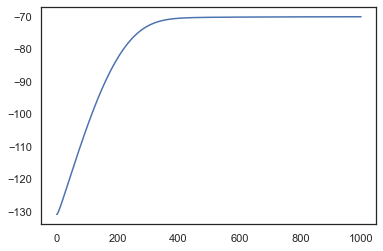

In [70]:
# ELBO
plt.plot(logf)

In [71]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.02904315185160243, 'test', 0.06658833535392399)

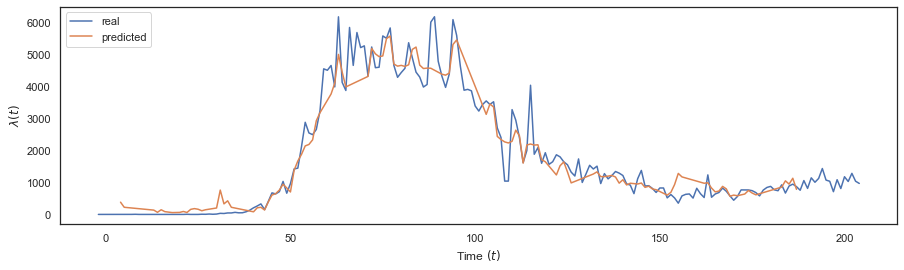

In [72]:
fig, ax = plt.subplots(figsize=(15, 4))

t_ = final_data_uk_cp[["index"]].to_numpy().reshape(-1)

_ = plt.plot(ms_uk_covid["index"] - 33, ms_uk_covid["ConfirmedChange"], label="real")

y_9 = y_scaler.inverse_transform(m.predict_f(X)[0].numpy()).reshape(-1)
_ = plt.plot(t_, y_9, alpha=1, label="predicted")

_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend(loc="upper left")